# Info about notebook...

This notebook... (Fill out later)

### Dataset Notes
**Retinal Image Dataset**
- Dataset can be found [here.](https://www.kaggle.com/datasets/ipythonx/retinal-vessel-segmentation) ***File size = 648.3 MB***
- Contains two mask types: Eye mask, and Retina mask.
- Only working with data in CHASE_DB1, and HRF
- Every single image in `CHASE_DB1/Images` has two masks in `CHASE_DB1/Masks`
- The masks within `CHASE_DB1/Masks` are represented as True/False **and not** 1/0

**Lung Segmentation Dataset**
- The dataset can be found or [here](https://github.com/IlliaOvcharenko/lung-segmentation/tree/master) or directly through this [link.](https://drive.google.com/file/d/1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ/view?usp=sharing) ***File size = 4.19GB***

**Skin Lesion Segmentation Dataset**
- The dataset can be found or [here](https://challenge.isic-archive.com/data/#2017) or directly through this [link.](https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip) The masks here are in superpixel format ***File size = 5.8GB***. Binary masks can be found [here](https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip) ***File size = 9MB***

# Library downloads.

In [1]:
!pip install gdown && pip install tifffile && git clone https://github.com/changzy00/pytorch-attention.git && pip install segmentation-models-pytorch

Cloning into 'pytorch-attention'...
remote: Enumerating objects: 739, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 739 (delta 46), reused 36 (delta 11), pack-reused 645
Receiving objects: 100% (739/739), 3.51 MiB | 18.51 MiB/s, done.
Resolving deltas: 100% (339/339), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.1 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.1 MB/s eta 0:00:0000:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=a285dd7728d647252dfa0b6e18f17ed3fbc9286a6451179da4320065ab6a0ab6
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911

# Importing Important Libraries

In [2]:
# File System Handling
import os
import gc
import gdown
import shutil
import tarfile
import zipfile

# Data Processing
import cv2
import tifffile
import requests
import numpy as np
import pandas as pd
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

# Image Visualization
from PIL import Image
import matplotlib.pyplot as plt

# Model Training, evaluation processes...
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from torchvision import transforms, models
from torch.cuda.amp import GradScaler, autocast

# Handling Warnings
import warnings
warnings.filterwarnings("ignore")

# Handling OutOfMemoryError
import multiprocessing
multiprocessing.set_start_method("spawn", force = True)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

#########################################
import torch.multiprocessing as mp
mp.set_sharing_strategy('file_system')
######################################### Re-run and change num workers back to >1.

# Advanced experiments (With different attentions).. Using os because of Shell, and Python environment awareness issue
os.chdir("pytorch-attention")
from attention_mechanisms.srm import SRM
from attention_mechanisms.cbam import CBAM
from attention_mechanisms.se_module import SELayer

print("All libraries succesfully imported, with configorations implemented.")

All libraries succesfully imported, with configorations implemented.


# Organizing Train images path

## Image Paths or Url

In [3]:
# Declaring all paths, and URLs.

# **Retina Images**
EYE_IMAGES_1 = "/kaggle/input/retinal-vessel-segmentation/CHASE_DB1/Images"
EYE_IMAGES_2 = "/kaggle/input/retinal-vessel-segmentation/HRF/images"

EYE_MASKS_1 = "/kaggle/input/retinal-vessel-segmentation/CHASE_DB1/Masks"
EYE_MASKS_2 = "/kaggle/input/retinal-vessel-segmentation/HRF/manual1"

# **Lungs Images**
# Sharing URL modified to Download URL
# FROM THIS FORMAT BELOW
# https://drive.google.com/file/d/FILE_ID/view?usp=sharing
# TO THIS FORMAT BELOW
# https://drive.google.com/uc?export=download&id=FILE_ID

LUNG_IMAGES = "https://drive.google.com/uc?export=download&id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ"
LUNG_BASE_DIR = "/kaggle/working/lungs/"
LUNG_IMAGES_DIR = os.path.join(LUNG_BASE_DIR, "dataset", "images")
LUNG_MASKS_DIR = os.path.join(LUNG_BASE_DIR, "dataset", "masks")

# **Skin Lesion Images**
SKIN_LESION_BASE_DIR = "/kaggle/working/skin_lesion"
SKIN_LESION_IMAGES = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip"
SKIN_LESION_BINARY_MASKS = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip"

# **Model, and Model Checkpoints**
latest_checkpoint_url = "https://drive.google.com/uc?export=download&id=1iNnXQPUNwmDyTD3Po_lz2rjHiNTEMiG7"
best_model_url = "https://drive.google.com/uc?export=download&id=18h_1UIO-vEfGuwLib1pSPuyySPsc8KVh"

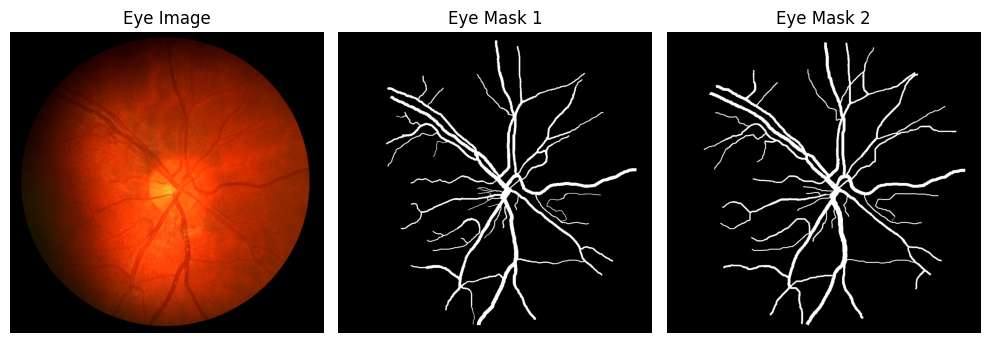

In [4]:
# Sample of an image an eye image and its two labels.
# Notice how they slightly differ?
# I will include both samples in training data as some form of
# augmentation as well.

# 0 > i < 14
i = "14" # Adjust to see different images. Numbers below 10 start with 0 e.g "02"

plt.subplots(1,3, figsize = (10,10))

plt.subplot(1,3,1)
plt.title("Eye Image")
im = Image.open(os.path.join(EYE_IMAGES_1, f"Image_{i}R.jpg"))
plt.imshow(im)
plt.axis(False);

plt.subplot(1,3,2)
plt.title("Eye Mask 1")
im = Image.open(os.path.join(EYE_MASKS_1, f"Image_{i}R_1stHO.png"))
plt.axis(False)
plt.imshow(im, cmap='gray')

plt.subplot(1,3,3)
plt.title("Eye Mask 2")
im = Image.open(os.path.join(EYE_MASKS_1, f"Image_{i}R_2ndHO.png"))
plt.axis(False)
plt.imshow(im, cmap='gray');
plt.tight_layout();

### Retina Images

In [5]:
# ============== Sorting Images and masks in CHASE_DB1 ============== #
image_paths = [] # list of images.
mask_paths = [] # list of corresponding image masks.

count = 0

for image in os.listdir(EYE_IMAGES_1): # Looping through every image
    image_masks = [] # List to store the two mask paths per image
    
    for mask in os.listdir(EYE_MASKS_1): # Looping through all masks
        if image[:9] in mask: # Checking if mask name has image name in it
            image_paths.append(os.path.join(EYE_IMAGES_1, image)) # Adding image path
            mask_paths.append(os.path.join(EYE_MASKS_1, mask)) # Adding corresponding mask path
            
image_paths = sorted(image_paths)
mask_paths = sorted(mask_paths)

# ============== Sorting Images and masks in HRF ============== #
retina_image_paths = sorted(image_paths + [os.path.join(EYE_IMAGES_2, path) for path in os.listdir(EYE_IMAGES_2)])
retina_mask_paths = sorted(mask_paths + [os.path.join(EYE_MASKS_2, path) for path in os.listdir(EYE_MASKS_2)])

print(f"Rentina:\nThere are {len(retina_image_paths)} training images, and {len(retina_mask_paths)} masks.")

Rentina:
There are 101 training images, and 101 masks.


### Lungs Images

In [4]:
# DO NOT RE-RUN UNLESS DATASET NOT ALREADY DOWNLOADED, AND SORTED.

# Creating base dir for lung images
os.makedirs(LUNG_BASE_DIR, exist_ok = True)

# Downloading dataset.
gdown.download(LUNG_IMAGES, LUNG_BASE_DIR, quiet = False)
print("Download completed.")

# Finding file.
zipped_file_name = [file.name for file in os.scandir(LUNG_BASE_DIR)][0]

# Extracting downloaded dataset
with tarfile.open(os.path.join(LUNG_BASE_DIR, zipped_file_name), "r:gz") as zip_ref:
    zip_ref.extractall(LUNG_BASE_DIR)
print("Image zip file content extracted")
    
# Deleting zipped file
os.remove(os.path.join(LUNG_BASE_DIR, zipped_file_name))
print("Zipped file deleted.")

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ
From (redirected): https://drive.google.com/uc?export=download&id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ&confirm=t&uuid=19c8a501-7a41-499c-8a42-1277aa28747c
To: /kaggle/working/lungs/dataset.tar.gz
100%|██████████| 4.40G/4.40G [00:37<00:00, 118MB/s] 


Download completed.
Image zip file content extracted
Zipped file deleted.


In [6]:
# Sorting Train Image Paths... Extracting first 704 lung images because there are only 704 masks.
lung_image_paths = sorted([os.path.join(LUNG_IMAGES_DIR, path) for path in os.listdir(LUNG_IMAGES_DIR)])
lung_mask_paths = sorted([os.path.join(LUNG_MASKS_DIR, path) for path in os.listdir(LUNG_MASKS_DIR)])

print(f"Lungs:\nThere are {len(lung_image_paths)} images, and {len(lung_mask_paths)} masks.")

masks = []
images = []

for image in os.listdir(LUNG_IMAGES_DIR):
    for mask in os.listdir(LUNG_MASKS_DIR):
        if image.split(".")[0] in mask.split(".")[0]:
            images.append(os.path.join(LUNG_IMAGES_DIR, image))
            masks.append(os.path.join(LUNG_MASKS_DIR, mask))

lung_image_paths = sorted(images)
lung_mask_paths = sorted(masks)

print(f"Matching Lungs:\nThere are {len(lung_image_paths)} images, and {len(lung_mask_paths)} masks.")

Lungs:
There are 800 images, and 704 masks.
Matching Lungs:
There are 704 images, and 704 masks.


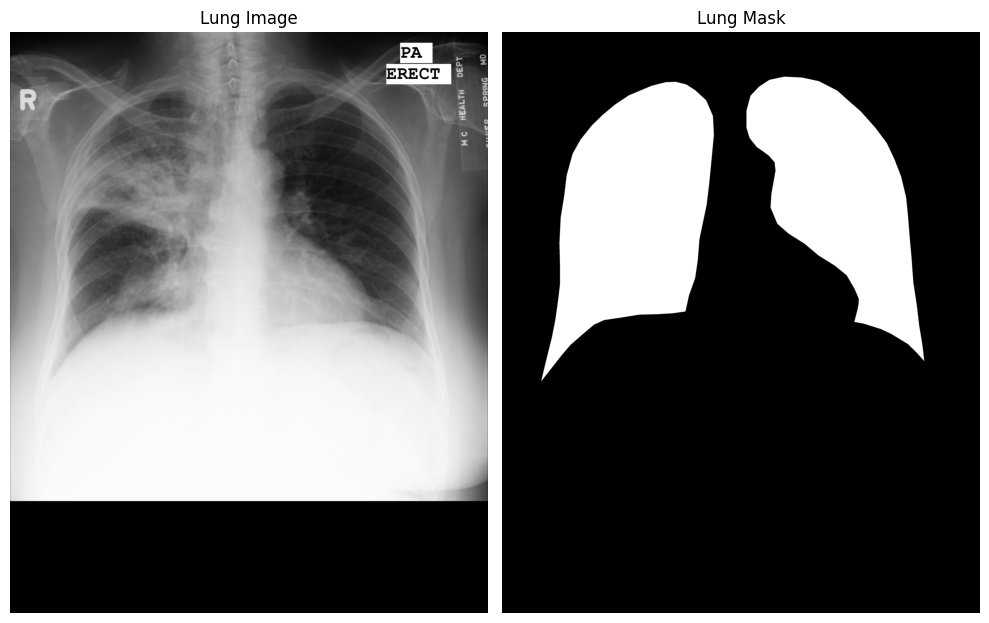

In [6]:
# Sample of a lung image and label.

# 0 >= i <= 703
i = 703 # Adjust to see different images.

plt.subplots(1,2, figsize = (10,10))

plt.subplot(1,2,1)
plt.title("Lung Image")
im = Image.open(lung_image_paths[i])
plt.imshow(im, cmap = "gray")
plt.axis(False);

plt.subplot(1,2,2)
plt.title("Lung Mask")
im = Image.open(lung_mask_paths[i])
plt.axis(False)
plt.imshow(im, cmap = "gray")

plt.tight_layout();

### Skin lesion Images

In [ ]:
# DO NOT RE-RUN UNLESS DATASET NOT ALREADY DOWNLOADED, AND SORTED.

# Creating base dir for lung images
os.makedirs(SKIN_LESION_BASE_DIR, exist_ok = True)

# Downloading dataset.
response = requests.get(SKIN_LESION_IMAGES, stream = True)

with open(os.path.join(SKIN_LESION_BASE_DIR, "dataset.zip"), 'wb') as file:
    for chunk in response.iter_content(chunk_size = 250):
        file.write(chunk)
print("Download completed.")

# Extract the contents of the zip file
with zipfile.ZipFile(os.path.join(SKIN_LESION_BASE_DIR, "dataset.zip"), 'r') as zip_ref:
    zip_ref.extractall(os.path.join(SKIN_LESION_BASE_DIR,'ISIC-2017_Training_Data'))
print("Image zip file content extracted")
    
# Deleting zipped file
os.remove(os.path.join(SKIN_LESION_BASE_DIR, "dataset.zip"))
print("Zipped file deleted.")

# Downloading binary masks.
response = requests.get(SKIN_LESION_BINARY_MASKS, stream = True)
with open(os.path.join(SKIN_LESION_BASE_DIR, "bin_mask.zip"), 'wb') as file:
    for chunk in response.iter_content(chunk_size = 128):
        file.write(chunk)
print("Download completed.")

# Extract the contents of the zip file
with zipfile.ZipFile(os.path.join(SKIN_LESION_BASE_DIR, "bin_mask.zip"), 'r') as zip_ref:
    zip_ref.extractall(os.path.join(SKIN_LESION_BASE_DIR, "2017_Training_Part1_GroundTruth"))
print("Image zip file content extracted")

os.remove(os.path.join(SKIN_LESION_BASE_DIR, "bin_mask.zip"))
print("Zipped file deleted.")


# Moving csv file out to avoid mismatch issues later.
os.rename(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Data", "ISIC-2017_Training_Data", "ISIC-2017_Training_Data_metadata.csv"), os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Data_metadata.csv"))
print("CSV moved to desired location.")

In [ ]:
csv_ = pd.read_csv(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Data_metadata.csv"))
csv_.head()

In [ ]:
#  -------------------->    ***TEMPORARY***: RE-RUN THIS CELL N-TIMES TILL TRAINING, AND TEST IMAGES = 2,000.     <--------------------

# Sorting Train Image Paths
lesion_image_paths = []
lesion_mask_paths = []

# ADJUST BAD LOGIC HERE LATER ;)
# RUN THIS ABOUT 3 TIMES TO HAVE THE FULL DATASET.
for path, bin_path in zip(
    os.scandir(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Data", "ISIC-2017_Training_Data")),
    os.scandir(os.path.join(SKIN_LESION_BASE_DIR, "2017_Training_Part1_GroundTruth", "ISIC-2017_Training_Part1_GroundTruth"))
):
    # Adding all binary label paths to list.
    lesion_mask_paths.append(bin_path.path)
    
    if path.name.endswith("jpg"): # Checking if the picture is jpg meaning image (superpixel masks)
        lesion_image_paths.append(path.path) # Adding all image paths to list
    
    elif path.name.endswith("png"): # Deleting "superpixel masks"
        os.remove(path.path)
        
# Sorting both lists so that images and labels match.
lesion_image_paths, lesion_mask_paths = sorted(lesion_image_paths), sorted(lesion_mask_paths)

print(f"Skin Lesion:\nThere are {len(lesion_image_paths)} images, and {len(lesion_mask_paths)} masks.")

In [ ]:
# Sample of a lesion image and label.

# 0 >= i <= 1999
i = 8 # Adjust to see different images.

plt.subplots(1,2, figsize = (10,10))

plt.subplot(1,2,1)
plt.title("Lesion Image")
image = Image.open(lesion_image_paths[i])
plt.imshow(image, cmap = "gray")
plt.axis(False);

plt.subplot(1,2,2)
plt.title("Lesion Mask")
mask = Image.open(lesion_mask_paths[i])
plt.axis(False)
plt.imshow(mask, cmap = "gray")

plt.tight_layout();

# Data Pre-processing & Augmentation

In [7]:
# FOR QUICK EXPERIMENTS. ##############

lung_image_paths = sorted(lung_image_paths)[:200]
lung_mask_paths = sorted(lung_mask_paths)[:200]

# Defining Standardz.
IMAGE_SIZE = (512, 512) # As seen on website. -> 520 for mobile net.
BATCH_SIZE = 4
BIN_THRESHOLD = 0.7 # For probabilities to class.
TEST_SIZE = 0.1 # Percentage of data to use for testing.
VAL_SIZE = 0.1 # Percentage of data to use for evaluation (During Training).
NUM_CLASSES = 1 # 1 because it is class against background.
LU_FULL = len(lung_image_paths) # Lungs full data amount

# Calculating TEST_SIZE, and VAL_SIZE for each data set.
lung_v_per = int(len(lung_image_paths) * VAL_SIZE) # Validation size

lung_t_per = int(len(lung_image_paths) * TEST_SIZE) # Test size

lung_train_images, lung_train_masks = lung_image_paths[:LU_FULL - (lung_v_per + lung_t_per)], lung_mask_paths[:LU_FULL - (lung_v_per + lung_t_per)] # First "n" file paths
lung_val_images, lung_val_masks = lung_image_paths[- (lung_v_per + lung_t_per): - lung_t_per], lung_mask_paths[- (lung_v_per + lung_t_per): - lung_t_per] # Next "n" starting at first n + 1 and stopping before last.
lung_test_images, lung_test_masks = lung_image_paths[- lung_t_per:], lung_mask_paths[- lung_t_per:] # Last "n"

full_train_image, full_train_mask = sorted(lung_train_images), sorted(lung_train_masks)
full_val_image, full_val_mask = sorted(lung_val_images), sorted(lung_val_masks)
full_test_image, full_test_mask = sorted(lung_test_images), sorted(lung_test_masks)

print(f"\nDataset Summary (Before Augmentation, and Transformations).\n")
print(f"{len(full_train_image)} training images, and {len(full_train_mask)} training masks")
print(f"{len(full_val_image)} validation images, and {len(full_val_mask)} validation masks")
print(f"{len(full_test_image)} test images, and {len(full_test_mask)} test masks\n")



Dataset Summary (Before Augmentation, and Transformations).

160 training images, and 160 training masks
20 validation images, and 20 validation masks
20 test images, and 20 test masks



In [11]:
# Defining Standardz.
IMAGE_SIZE = (512, 512) # As seen on website. -> 520 for mobile net.
BATCH_SIZE = 4
BIN_THRESHOLD = 0.5 # For probabilities to class.
TEST_SIZE = 0.1 # Percentage of data to use for testing.
VAL_SIZE = 0.1 # Percentage of data to use for evaluation (During Training).
NUM_CLASSES = 1 # 1 because it is class against background.
R_FULL = len(retina_image_paths) # Retina full data amount 
LU_FULL = len(lung_image_paths) # Lungs full data amount
LE_FULL = len(lesion_image_paths) # Lesion full data amount

# Calculating TEST_SIZE, and VAL_SIZE for each data set.
retina_v_per = int(len(retina_image_paths) * VAL_SIZE) # Validation size
lung_v_per = int(len(lung_image_paths) * VAL_SIZE) # Validation size
lesion_v_per = int(len(lesion_image_paths) * VAL_SIZE) # Validation size

retina_t_per = int(len(retina_image_paths) * TEST_SIZE) # Test size
lung_t_per = int(len(lung_image_paths) * TEST_SIZE) # Test size
lesion_t_per = int(len(lesion_image_paths) * TEST_SIZE) # Test size

# Extracting Training, Test, and Validation data... Extracting first, and last n file paths.
retina_train_images, retina_train_masks = retina_image_paths[:R_FULL - (retina_v_per + retina_t_per)], retina_mask_paths[:R_FULL - (retina_v_per + retina_t_per)] # First "n" file paths
retina_val_images, retina_val_masks = retina_image_paths[- (retina_v_per + retina_t_per): - retina_t_per], retina_mask_paths[- (retina_v_per + retina_t_per): - retina_t_per] # Next "n" starting at first n + 1 and stopping before last.
retina_test_images, retina_test_masks = retina_image_paths[- retina_t_per:], retina_mask_paths[- retina_t_per:] # Last "n"

lung_train_images, lung_train_masks = lung_image_paths[:LU_FULL - (lung_v_per + lung_t_per)], lung_mask_paths[:LU_FULL - (lung_v_per + lung_t_per)] # First "n" file paths
lung_val_images, lung_val_masks = lung_image_paths[- (lung_v_per + lung_t_per): - lung_t_per], lung_mask_paths[- (lung_v_per + lung_t_per): - lung_t_per] # Next "n" starting at first n + 1 and stopping before last.
lung_test_images, lung_test_masks = lung_image_paths[- lung_t_per:], lung_mask_paths[- lung_t_per:] # Last "n"

lesion_train_images, lesion_train_masks = lesion_image_paths[:LE_FULL - (lesion_v_per + lesion_t_per)], lesion_mask_paths[:LE_FULL - (lesion_v_per + lesion_t_per)] # First "n" file paths
lesion_val_images, lesion_val_masks = lesion_image_paths[- (lesion_v_per + lesion_t_per): - lesion_t_per], lesion_mask_paths[- (lesion_v_per + lesion_t_per): - lesion_t_per] # Next "n" starting at first n + 1 and stopping before last.
lesion_test_images, lesion_test_masks = lesion_image_paths[- lesion_t_per:], lesion_mask_paths[- lesion_t_per:] # Last "n"

full_train_image, full_train_mask = sorted((retina_train_images + lung_train_images + lesion_train_images)), sorted((retina_train_masks + lung_train_masks + lesion_train_masks))
full_val_image, full_val_mask = sorted((retina_val_images + lung_val_images + lesion_val_images)), sorted((retina_val_masks + lung_val_masks + lesion_val_masks))
full_test_image, full_test_mask = sorted((retina_test_images + lung_test_images + lesion_test_images)), sorted((retina_test_masks + lung_test_masks + lesion_test_masks))

print(f"\nDataset Summary (Before Augmentation, and Transformations).\n")
print(f"{len(full_train_image)} training images, and {len(full_train_mask)} training masks")
print(f"{len(full_val_image)} validation images, and {len(full_val_mask)} validation masks")
print(f"{len(full_test_image)} test images, and {len(full_test_mask)} test masks\n")

print("=" * 74)
print(f"||--------||  Training\t||  Validation\t||\tTest\t||     Total\t||")
print("-" * 74)
print(f"|| Retina ||\t{len(retina_train_images)}\t||\t{len(retina_val_images)}\t||\t{len(retina_test_images)}\t||\t{R_FULL}\t||")
print(f"|| Lungs  ||\t{len(lung_train_images)}\t||\t{len(lung_val_images)}\t||\t{len(lung_val_images)}\t||\t{LU_FULL}\t||")
print(f"|| Lesion ||\t{len(lesion_train_images)}\t||\t{len(lesion_val_images)}\t||\t{len(lesion_test_images)}\t||\t{LE_FULL}\t||")
print("=" * 74)

## Defining Augmentation Pipeline

### Important Augmentation, and visualization Functions.

In [8]:
class CustomDataset(Dataset):
    def __init__(self, images_paths, labels_paths, train=True, image_size=(512, 512)):
        self.images_paths = images_paths
        self.labels_paths = labels_paths
        self.image_size = image_size
        self.train = train

        self.image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        ])

        # Convert PNG to JPEG
        self.convert_png_to_jpeg()

    def __len__(self):
        return len(self.images_paths) * (2 if self.train else 1)
    
    def __getitem__(self, idx):
        original_idx = idx // 2 if self.train else idx
        is_augmented = self.train and idx % 2 == 1

        image_path = self.images_paths[original_idx]
        label_path = self.labels_paths[original_idx]

        # Read image
        image = Image.open(image_path).convert("RGB")
        
        # Read mask
        if label_path.lower().endswith(".tif") or label_path.lower().endswith(".tiff"):
            mask = tifffile.imread(label_path)
        else:
            mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        
        mask = (mask > 0).astype(np.uint8) * 255  # Ensure binary
        mask = Image.fromarray(mask)

        # Apply augmentations if needed
        if is_augmented:
            image, mask = self.apply_augmentations(image, mask)

        # Apply transformations
        image = self.image_transform(image)
        
        # For mask, use custom transformation to ensure binary output
        mask = TF.resize(mask, self.image_size)
        mask = TF.to_tensor(mask)
        mask = (mask > 0.5).float()  # Ensure binary

        return image, mask

    def apply_augmentations(self, image, mask):
        # Random horizontal flipping
        if torch.rand(1) < 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        
        # Random vertical flipping
        if torch.rand(1) < 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        
        # Random rotation
        if torch.rand(1) < 0.5:
            angle = torch.randint(-30, 30, (1,)).item()
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)
        
        # Random affine transform
        if torch.rand(1) < 0.5:
            angle = torch.randint(-10, 10, (1,)).item()
            translate = [torch.randint(-20, 20, (1,)).item() / 100.0 for _ in range(2)]
            scale = 1.0 + torch.randint(-10, 10, (1,)).item() / 100.0
            shear = torch.randint(-10, 10, (1,)).item()
            image = TF.affine(image, angle, translate, scale, shear)
            mask = TF.affine(mask, angle, translate, scale, shear)
        
        return image, mask

    def convert_png_to_jpeg(self):
        for i, img_path in enumerate(self.images_paths):
            if img_path.lower().endswith(".png"):
                jpeg_path = os.path.splitext(img_path)[0] + ".jpg"
                if not os.path.exists(jpeg_path):
                    with Image.open(img_path) as img:
                        rgb_img = img.convert("RGB")
                        rgb_img.save(jpeg_path, "JPEG")
                self.images_paths[i] = jpeg_path
    

class DiceBCELoss(nn.Module):
    def __init__(self, weight = 0.5):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.weight = weight

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        
        probs = torch.sigmoid(logits)
        probs = probs.view(probs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        
        intersection = (probs * targets).sum(1)
        total = probs.sum(1) + targets.sum(1)
        
        dice_loss = 1 - ((2. * intersection + 1e-5) / (total + 1e-5)).mean()
        
        return (1 - self.weight) * bce_loss + self.weight * dice_loss

    
def image_denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    img_array = tensor.permute(1, 2, 0).numpy()
    return img_array


def pred_nd_plot(test_loader, model, device, image_denormalize, pred_threshold = 0.5, num_images = 10):
    """
    For plotting image, its true mask, predicted mask, and predicted mask on image overlap.
    """
    model.eval()  # Set the model to evaluation mode
    it = iter(test_loader)
    
    for _ in range(num_images):
        try:
            image, mask = next(it)
        except StopIteration:
            print("Reached the end of the test loader.")
            break

        plt.figure(figsize = (12, 5))
        
        # Display the original image
        plt.subplot(1, 4, 1)
        plt.title("Image")
        plt.imshow(image_denormalize(image[0]))
        plt.axis(False)

        # Display the true mask
        plt.subplot(1, 4, 2)
        plt.title("True Mask")
        plt.imshow(mask[0][0], cmap = "gray")
        plt.axis(False)

        with torch.no_grad():
            # Transfer data to GPU asynchronously
            pred_image = image.to(device, non_blocking = True)
            output = model(pred_image)
            output = torch.sigmoid(output)
            output = (output > pred_threshold).float()

        # Display the predicted mask
        plt.subplot(1, 4, 3)
        plt.title(f"Predicted Mask - Threshold Value ({pred_threshold})")
        plt.imshow(np.array(output.cpu())[0][0], cmap="gray")
        plt.axis(False)

        # Diaplay mask over image
        plt.subplot(1, 4, 4)
        plt.title("Image-Mask Overlay")
        plt.imshow(image_denormalize(image[0]), alpha=0.5)
        plt.imshow(np.array(output.cpu())[0][0], cmap='jet', alpha=0.7)
        plt.axis(False)

        plt.tight_layout()
        plt.show()
        
        
def pred_plot_compare(test_loader, model_1, model_2, device, image_denormalize, pred_threshold = 0.5, num_images = 10):
    """
    For plotting image, its true mask, predicted mask (by first model), and predicted mask (by second model).
    """
    model_1.eval()
    model_2.eval()
    it = iter(test_loader)
    
    for i in range(num_images):
        try:
            image, mask = next(it)
        except StopIteration:
            print("Reached the end of the test loader.")
            break
        
        plt.figure(figsize = (20, 5))
        
        # Display the original image
        plt.subplot(1, 4, 1)
        plt.title("Image")
        plt.imshow(image_denormalize(image[0]))
        plt.axis('off')
        
        # Display the true mask
        plt.subplot(1, 4, 2)
        plt.title("True Mask")
        plt.imshow(mask[0][0], cmap = "gray")
        plt.axis('off')
        
        with torch.no_grad():
            # Transfer data to GPU asynchronously
            pred_image = image.to(device, non_blocking=True)
            
            # Predict with model_1
            output_1 = model_1(pred_image)
            output_1 = torch.sigmoid(output_1)
            output_1 = (output_1 > pred_threshold).float()
            
            # Predict with model_2
            output_2 = model_2(pred_image)
            output_2 = torch.sigmoid(output_2)
            output_2 = (output_2 > pred_threshold).float()
        
        # Display the predicted mask from model_1
        plt.subplot(1, 4, 3)
        plt.title(f"Model 1 Pred - Threshold ({pred_threshold})")
        plt.imshow(np.array(output_1.cpu())[0][0], cmap = "gray")
        plt.axis('off')
        
        # Display the predicted mask from model_2
        plt.subplot(1, 4, 4)
        plt.title(f"Model 2 Pred - Threshold ({pred_threshold})")
        plt.imshow(np.array(output_2.cpu())[0][0], cmap = "gray")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()    
            
            
class ModelTrainer:
    def __init__(self, model, criterion, optimizer, train_loader, validation_loader, device, 
                 checkpoint_dir = "/kaggle/working/ModelTrainingCheckpoint", type_ = "base", 
                 bin_threshold = 0.5, num_epochs = 50, accumulation_steps = 4):
        """
        INPUTS:
            [model]: Instance of the model to be trained.
            [criterion]: Loss/Cost function for training... could be customized as well.
            [optimizer]: Optimization function e.g Adam with learning rate specified.
            [train_loader]: Function for training data loading
            [validation_loader]: Function for validation data loading
            [device]: CPU or cuda ... used to determine where to send data during training
            [checkpoint_dir]: Base directory path for saving best model and latest checkpoints... **default** = /kaggle/working/ModelTrainingCheckpoint
            [type_]: Type of model for experiment tracking... e.g model trained with CBAM will be passed as "cbam". **default** = base
            [bin_threshold]: Threshold value for logit conversion to binary class **default** = 0.5
            [num_epochs]: Number of training epochs... **default** = 50
            [accumulation_steps]: max accumulation steps for gradient accumulation **default** = 4
        
        OUTPUTS:
            [model]: Trained model / Model at last complete epoch.
            [epochs]: Number of epochs completed.
            [train_ious]: IoU on training dataset.
            [train_dices]: Dice score on training set
            [train_losses]: Loss on training set
            [val_ious]: IoU on validation set
            [val_dices]: Dice score on validation set
            [val_losses]: Loss on validation set
        """
        
        # Training related
        self.model = model
        self.type_ = type_
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.num_epochs = num_epochs
        self.train_loader = train_loader
        self.bin_threshold = bin_threshold
        self.checkpoint_dir = checkpoint_dir
        self.validation_loader = validation_loader
        self.accumulation_steps = accumulation_steps
        
        # Checkpointing related
        self.checkpoint_path = os.path.join(checkpoint_dir, f"best_{type_}_model.pth")
        self.latest_checkpoint_path = os.path.join(checkpoint_dir, f"latest_{type_}_checkpoint.pth")
        
        # Initialization of key values.
        self.best_val_iou = float("inf")
        self.best_val_loss = float("inf")
        self.start_epoch = 0
        
        # Collecting for visualization.
        self.epochs = []
        self.train_ious, self.train_dices, self.train_losses = [], [], []
        self.val_ious, self.val_dices, self.val_losses = [], [], []
        
        self.scaler = GradScaler()
        
        self._create_checkpoint_dir()
        self._load_checkpoint()

    def _create_checkpoint_dir(self):
        os.makedirs(self.checkpoint_dir, exist_ok = True)

    def _load_checkpoint(self):
        if os.path.exists(self.latest_checkpoint_path):
            checkpoint = torch.load(self.latest_checkpoint_path)
            self.model.load_state_dict(checkpoint["model_state_dict"])
            self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            self.start_epoch = checkpoint["epoch"] + 1
            self.best_val_iou = checkpoint["best_val_iou"]
            self.best_val_loss = checkpoint["best_val_loss"]
            print(f"Resuming training from epoch {self.start_epoch}")
        else:
            print("Starting training from scratch")

    @staticmethod
    def calculate_iou_dice(outputs, targets, threshold):
        # Ensure outputs and targets are the same shape
        assert outputs.shape == targets.shape, f"Shape mismatch: outputs {outputs.shape}, targets {targets.shape}"

        # Binarize the outputs
        outputs = (outputs > threshold).float()
        targets = targets.float()

        # Flatten the tensors
        outputs = outputs.view(outputs.size(0), -1)
        targets = targets.view(targets.size(0), -1)

        intersection = (outputs * targets).sum(1)
        union = outputs.sum(1) + targets.sum(1) - intersection

        iou = (intersection + 1e-6) / (union + 1e-6)
        dice = (2 * intersection + 1e-6) / (outputs.sum(1) + targets.sum(1) + 1e-6)

        return iou.mean(), dice.mean()

    def train(self):
        print(f"\nTraining on: {self.device}, version {torch.version.cuda}")
        print(f"'{self.type_}' training Started... LET's GOOOOOOO !!!!!")
        
        for epoch in range(self.start_epoch, self.num_epochs):
            self._train_epoch(epoch)
            self._validate_epoch(epoch)
            self._save_checkpoint(epoch)
            
            print(f"Epoch {epoch+1}/{self.num_epochs} ====== "
                  f"Training : (Loss: {self.train_losses[-1]:.4f} - IoU: {self.train_ious[-1]:.4f} - Dice: {self.train_dices[-1]:.4f}) *=* "
                  f"Validation : (Loss: {self.val_losses[-1]:.4f} - IoU: {self.val_ious[-1]:.4f} - Dice: {self.val_dices[-1]:.4f})")
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            torch.cuda.synchronize()

        return {
            "model": self.model,
            "epochs": self.epochs,
            "train_ious": self.train_ious,
            "train_dices": self.train_dices,
            "train_losses": self.train_losses,
            "val_ious": self.val_ious,
            "val_dices": self.val_dices,
            "val_losses": self.val_losses
        }

    def _train_epoch(self, epoch):
        self.model.train()
        running_loss = running_iou = running_dice = 0.0
        self.epochs.append(epoch + 1)
        accumulated_steps = 0

        for i, (images, masks) in enumerate(self.train_loader):
            images = images.to(self.device, non_blocking = True)
            masks = masks.to(self.device, non_blocking = True)

            self.optimizer.zero_grad()
            with autocast():
                outputs = self.model(images)
                loss = self.criterion(outputs, masks.float())

            self.scaler.scale(loss).backward()

            accumulated_steps += 1
            if accumulated_steps % self.accumulation_steps == 0 or i == len(self.train_loader) - 1:
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()

            iou, dice = self.calculate_iou_dice(outputs, masks, self.bin_threshold)

            running_loss += loss.item() * images.size(0)
            running_iou += iou.item() * images.size(0)
            running_dice += dice.item() * images.size(0)

        self.train_losses.append(running_loss / len(self.train_loader.dataset))
        self.train_ious.append(running_iou / len(self.train_loader.dataset))
        self.train_dices.append(running_dice / len(self.train_loader.dataset))

    def _validate_epoch(self, epoch):
        self.model.eval()
        val_loss = val_iou = val_dice = 0.0

        with torch.no_grad():
            for images, masks in self.validation_loader:
                images = images.to(self.device, non_blocking = True)
                masks = masks.to(self.device, non_blocking = True)
                
                with autocast():
                    outputs = self.model(images)
                    loss = self.criterion(outputs, masks)
                
                iou, dice = self.calculate_iou_dice(outputs, masks, self.bin_threshold)

                val_loss += loss.item() * images.size(0)
                val_iou += iou.item() * images.size(0)
                val_dice += dice.item() * images.size(0)

        self.val_losses.append(val_loss / len(self.validation_loader.dataset))
        self.val_ious.append(val_iou / len(self.validation_loader.dataset))
        self.val_dices.append(val_dice / len(self.validation_loader.dataset))

    def _save_checkpoint(self, epoch):
        torch.save({
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "best_val_iou": self.best_val_iou,
            "best_val_loss": self.best_val_loss,
        }, self.latest_checkpoint_path)

        if (self.val_ious[-1] > self.best_val_iou) or (self.val_losses[-1] < self.best_val_loss):
            self.best_val_iou = max(self.val_ious[-1], self.best_val_iou)
            self.best_val_loss = min(self.val_losses[-1], self.best_val_loss)
            torch.save(self.model.state_dict(), self.checkpoint_path)
            message = "Higher IoU." if self.val_ious[-1] > self.best_val_iou else "Lower Loss."
            print(f"New Best Model Saved! - {message}")

            
# EXPERIMENTAL ASPECTS
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
        self.softmax = nn.Softmax(dim = -1)
        
    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        
        out = self.gamma * out + x
        return out

In [9]:
train_dataset = CustomDataset(full_train_image, full_train_mask, train = True, image_size = IMAGE_SIZE)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

# Loading validation data
validation_dataset = CustomDataset(full_val_image, full_val_mask, train = False, image_size = IMAGE_SIZE)
validation_loader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

# Loading Test data
test_dataset = CustomDataset(full_test_image, full_test_mask, train = False, image_size = IMAGE_SIZE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

print(f"Dataset Summary (Post-Augmentation, and Transformations).\n")
print("=" * 66)
print(f"||----------------||   Training\t||  Validation\t||\tTest\t||")
print("-" * 66)
print(f"|| Full Dataset   ||\t{len(train_dataset)}\t||\t{len(validation_dataset)}\t||\t{len(test_dataset)}\t||")
print(f"|| Batch Size\t  ||\t{len(train_dataset)//len(train_loader)}\t||\t{len(validation_dataset)//len(validation_loader)}\t||\t{len(test_dataset)//len(test_loader)}\t||")
print(f"|| No. of Batches ||\t{len(train_loader)}\t||\t{len(validation_loader)}\t||\t{len(test_loader)}\t||")
print("=" * 66)

Dataset Summary (Post-Augmentation, and Transformations).

||----------------||   Training	||  Validation	||	Test	||
------------------------------------------------------------------
|| Full Dataset   ||	320	||	20	||	20	||
|| Batch Size	  ||	4	||	4	||	4	||
|| No. of Batches ||	80	||	5	||	5	||


# Model Architecture Definition, Training & evaluation

## Various Architecture Definitions

In [10]:
# BASE DEEP LABS V3 MODEL.
class DeepLabsV3(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabsV3, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet50(pretrained = True)
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size = (1, 1), stride = (1, 1))
        
    def forward(self, x):
        return self.model(x)["out"]


# DEEP LABS V3 MODEL WITH JUST CBAM ATTENTION
class DeepLabV3WithCBAM(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3WithCBAM, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet50(pretrained=True)
        
        # Getting the number of channels in the last layer of the backbone
        backbone_out_channels = self.model.backbone["layer4"][-1].conv3.out_channels
        
        # Adding CBAM after backbone
        self.cbam = CBAM(backbone_out_channels)
        
        # Modify the classifier
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size = (1, 1), stride=(1, 1))
        
        # upsampling layer to avoid down scale error during training.
        self.upsample = nn.Upsample(scale_factor = 8, mode = "bilinear", align_corners = True)
        
    def forward(self, x):
        # Get features from the backbone
        features = self.model.backbone(x)
        
        # Apply CBAM to the features
        attention_features = self.cbam(features["out"])
        
        # Using refined features for the rest of the model
        x = self.model.classifier(attention_features)
        
        # Upsample the output to match input size
        x = self.upsample(x)
        
        return x


# DEEP LABS V3 MODEL WITH JUST CBAM AND SELF-ATTENTION (SERIAL)
class DeepLabV3WithSelfCBAM(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3WithSelfCBAM, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet50(pretrained=True)

        # Getting the number of channels in the last layer of the backbone
        backbone_out_channels = self.model.backbone["layer4"][-1].conv3.out_channels

        # Adding CBAM after backbone
        self.cbam = CBAM(backbone_out_channels)

        # Adding self-attention after CBAM
        self.self_attention = SelfAttention(backbone_out_channels)

        # Modify the classifier
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size = (1, 1), stride = (1, 1))

        # Upsampling layer to avoid downscale error during training
        self.upsample = nn.Upsample(scale_factor = 8, mode="bilinear", align_corners = True)

    def forward(self, x):
        # Get features from the backbone
        features = self.model.backbone(x)

        # Apply CBAM to the features
        attention_features = self.cbam(features["out"])

        # Apply self-attention to the features
        self_attention_features = self.self_attention(attention_features)

        # Using refined features for the rest of the model
        x = self.model.classifier(self_attention_features)

        # Upsample the output to match input size
        x = self.upsample(x)

        return x

    
# DEEP LABS V3 MODEL WITH CBAM AND SELF-ATTENTION (SERIAL) + PARALLEL SELF-ATTENTION
class DeepLabV3PlusWithCBAMSAx2(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3PlusWithCBAMSAx2, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet50(pretrained = True)
        
        # Getting the number of channels in the last layer of the backbone
        backbone_out_channels = self.model.backbone["layer4"][-1].conv3.out_channels
        
        # Adding CBAM after backbone
        self.cbam = CBAM(backbone_out_channels)
        
        # Adding serial self-attention after CBAM
        self.serial_self_attention = SelfAttention(backbone_out_channels)
        
        # Adding parallel self-attention to backbone output
        self.parallel_self_attention = SelfAttention(backbone_out_channels)
        
        # Modify the classifier
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size = (1, 1), stride = (1, 1))
        
        # Upsampling layer to avoid downscale error during training
        self.upsample = nn.Upsample(scale_factor = 8, mode = "bilinear", align_corners = True)

    def forward(self, x):
        # Get features from the backbone
        features = self.model.backbone(x)
        
        # Apply CBAM to the features
        cbam_features = self.cbam(features["out"])
        
        # Apply serial self-attention to the CBAM features
        serial_attention_features = self.serial_self_attention(cbam_features)
        
        # Apply parallel self-attention to the backbone features
        parallel_attention_features = self.parallel_self_attention(features["out"])
        
        # Combine the serial and parallel attention features
        combined_features = serial_attention_features + parallel_attention_features
        
        # Using combined features for the rest of the model
        x = self.model.classifier(combined_features)
        
        # Upsample the output to match input size
        x = self.upsample(x)
        
        return x
    

# DEEP LABS V3 MODEL WITH JUST SELayer ATTENTION
class DeepLabV3WithSELayer(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3WithSELayer, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet50(pretrained=True)
        
        # Getting the number of channels in the last layer of the backbone
        backbone_out_channels = self.model.backbone["layer4"][-1].conv3.out_channels
        
        # Adding SELayer after backbone
        self.SELayer = SELayer(backbone_out_channels)
        
        # Modify the classifier
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size = (1, 1), stride=(1, 1))
        
        # upsampling layer to avoid down scale error during training.
        self.upsample = nn.Upsample(scale_factor = 8, mode = "bilinear", align_corners = True)
        
    def forward(self, x):
        # Get features from the backbone
        features = self.model.backbone(x)
        
        # Apply SELayer to the features
        attention_features = self.SELayer(features["out"])
        
        # Using refined features for the rest of the model
        x = self.model.classifier(attention_features)
        
        # Upsample the output to match input size
        x = self.upsample(x)
        
        return x
    
    
# ATTENTION IN ENCODER AND DECODER.
class DeepLabV3WithCBAMInENDandDEC(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3WithCBAMInENDandDEC, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet50(pretrained=True)
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
        self.cbam1 = CBAM(256)
        self.cbam2 = CBAM(512)
        self.cbam3 = CBAM(1024)
        self.cbam4 = CBAM(2048)
        self.num_classes = num_classes
        
    def forward(self, x):
        input_size = x.size()[2:]
        x = self.model.backbone.conv1(x)
        x = self.model.backbone.bn1(x)
        x = self.model.backbone.relu(x)
        x = self.model.backbone.maxpool(x)
        x = self.model.backbone.layer1(x)
        x = self.cbam1(x)
        x = self.model.backbone.layer2(x)
        x = self.cbam2(x)
        x = self.model.backbone.layer3(x)
        x = self.cbam3(x)
        x = self.model.backbone.layer4(x)
        x = self.cbam4(x)
        x = self.model.classifier(x)
        if self.num_classes == 1:
            x = torch.sigmoid(x)
        x = nn.functional.interpolate(x, size = input_size, mode = "bilinear", align_corners = False)
        return x


class DeepLabV3WithSRMInENCandDEC(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3WithSRMInENCandDEC, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet50(pretrained=True)
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
        self.srm1 = SRM(256)
        self.srm2 = SRM(512)
        self.srm3 = SRM(1024)
        self.srm4 = SRM(2048)
        self.num_classes = num_classes
        
    def forward(self, x):
        input_size = x.size()[2:]
        x = self.model.backbone.conv1(x)
        x = self.model.backbone.bn1(x)
        x = self.model.backbone.relu(x)
        x = self.model.backbone.maxpool(x)
        x = self.model.backbone.layer1(x)
        x = self.srm1(x)
        x = self.model.backbone.layer2(x)
        x = self.srm2(x)
        x = self.model.backbone.layer3(x)
        x = self.srm3(x)
        x = self.model.backbone.layer4(x)
        x = self.srm4(x)
        x = self.model.classifier(x)
        if self.num_classes == 1:
            x = torch.sigmoid(x)
        x = nn.functional.interpolate(x, size = input_size, mode = "bilinear", align_corners = False)
        return x


class DeepLabV3WithCBAM(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3WithCBAM, self).__init__()
        
        # Load the pretrained DeepLabV3 model
        self.model = models.segmentation.deeplabv3_resnet50(pretrained=True)
        
        # Replace the classifier to match the number of output classes
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
        
        # Apply CBAM to the encoder stages (ResNet backbone)
        self.cbam1 = CBAM(256)  # Adjusted to match the channels after layer1
        self.cbam2 = CBAM(512)  # Adjusted to match the channels after layer2
        self.cbam3 = CBAM(1024)  # Adjusted to match the channels after layer3
        self.cbam4 = CBAM(2048)  # Adjusted to match the channels after layer4

    def forward(self, x):
        input_size = x.size()[2:]  # Store the original input size for upsampling
        
        # Encoder: Apply CBAM after each layer
        x = self.model.backbone.conv1(x)
        x = self.model.backbone.bn1(x)
        x = self.model.backbone.relu(x)
        x = self.model.backbone.maxpool(x)
        
        x = self.model.backbone.layer1(x)
        x = self.cbam1(x)  # Apply CBAM after layer1
        
        x = self.model.backbone.layer2(x)
        x = self.cbam2(x)  # Apply CBAM after layer2
        
        x = self.model.backbone.layer3(x)
        x = self.cbam3(x)  # Apply CBAM after layer3
        
        x = self.model.backbone.layer4(x)
        x = self.cbam4(x)  # Apply CBAM after layer4
        
        # Decoder
        x = self.model.classifier(x)  # This layer outputs num_classes channels
        
        # Upsample to match the input resolution
        x = nn.functional.interpolate(x, size=input_size, mode='bilinear', align_corners=False)
        
        return x


class DeepLabV3WithSELayerAttention(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3WithSELayerAttention, self).__init__()
        
        # Load the pretrained DeepLabV3 model
        self.model = models.segmentation.deeplabv3_resnet50(pretrained=True)
        
        # Replace the classifier to match the number of output classes
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
        
        # Apply CBAM to the encoder stages (ResNet backbone)
        self.selayer1 = SELayer(256)  # Adjusted to match the channels after layer1
        self.selayer2 = SELayer(512)  # Adjusted to match the channels after layer2
        self.selayer3 = SELayer(1024)  # Adjusted to match the channels after layer3
        self.selayer4 = SELayer(2048)  # Adjusted to match the channels after layer4

    def forward(self, x):
        input_size = x.size()[2:]  # Store the original input size for upsampling
        
        # Encoder: Apply CBAM after each layer
        x = self.model.backbone.conv1(x)
        x = self.model.backbone.bn1(x)
        x = self.model.backbone.relu(x)
        x = self.model.backbone.maxpool(x)
        
        x = self.model.backbone.layer1(x)
        x = self.selayer1(x)  # Apply SELayer after layer1
        
        x = self.model.backbone.layer2(x)
        x = self.selayer2(x)  # Apply SELayer after layer2
        
        x = self.model.backbone.layer3(x)
        x = self.selayer3(x)  # Apply SELayer after layer3
        
        x = self.model.backbone.layer4(x)
        x = self.selayer4(x)  # Apply SELayer after layer4
        
        # Decoder
        x = self.model.classifier(x)  # This layer outputs num_classes channels
        
        # Upsample to match the input resolution
        x = nn.functional.interpolate(x, size=input_size, mode='bilinear', align_corners=False)
        
        return x


class DeepLabV3WithCbamSEAlternativeAttention(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3WithCbamSEAlternativeAttention, self).__init__()
        
        # Load the pretrained DeepLabV3 model
        self.model = models.segmentation.deeplabv3_resnet50(pretrained=True)
        
        # Replace the classifier to match the number of output classes
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
        
        # Apply CBAM and SelfAttention alternately to the encoder stages (ResNet backbone)
        self.attention1 = CBAM(256)  # Apply CBAM after layer1
        self.attention2 = SELayer(512)  # Apply SelfAttention after layer2
        self.attention3 = CBAM(1024)  # Apply CBAM after layer3
        self.attention4 = SELayer(2048)  # Apply SelfAttention after layer4

    def forward(self, x):
        input_size = x.size()[2:]  # Store the original input size for upsampling
        
        # Encoder: Apply CBAM and SelfAttention alternately after each layer
        x = self.model.backbone.conv1(x)
        x = self.model.backbone.bn1(x)
        x = self.model.backbone.relu(x)
        x = self.model.backbone.maxpool(x)
        
        x = self.model.backbone.layer1(x)
        x = self.attention1(x)  # Apply CBAM after layer1
        
        x = self.model.backbone.layer2(x)
        x = self.attention2(x)  # Apply SELayer after layer2
        
        x = self.model.backbone.layer3(x)
        x = self.attention3(x)  # Apply CBAM after layer3
        
        x = self.model.backbone.layer4(x)
        x = self.attention4(x)  # Apply SELayer after layer4
        
        # Decoder
        x = self.model.classifier(x)  # This layer outputs num_classes channels
        
        # Upsample to match the input resolution
        x = nn.functional.interpolate(x, size=input_size, mode='bilinear', align_corners=False)
        
        return x



# ====== DEEP LABS V3+ FROM HERE ====== #
class DeepLabsV3Plus(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabsV3Plus, self).__init__()
        self.model = smp.DeepLabV3Plus(
            encoder_name="resnet50", 
            encoder_weights="imagenet", 
            classes=num_classes, 
            activation=None)
        
    def forward(self, x):
        return self.model(x)


class DeepLabV3PlusWithLayerWiseCBAM(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3PlusWithLayerWiseCBAM, self).__init__()
        self.model = smp.DeepLabV3Plus(
            encoder_name="resnet50", 
            encoder_weights="imagenet", 
            classes=num_classes, 
            activation=None
        )
        self.encoder = self.model.encoder
        self.decoder = self.model.decoder
        self.segmentation_head = self.model.segmentation_head
        
        # Initialize CBAM modules for each encoder stage with correct channel sizes
        self.cbam1 = CBAM(64)    # After first layer (Feature 1)
        self.cbam2 = CBAM(256)   # After second layer (Feature 2)
        self.cbam3 = CBAM(512)   # After third layer (Feature 3)
        self.cbam4 = CBAM(1024)  # After fourth layer (Feature 4)
        self.cbam5 = CBAM(2048)  # After fifth layer (Feature 5)

    def forward(self, x):
        input_size = x.size()[2:]
        
        # Get features from encoder
        features = self.encoder(x)
        
        # Apply CBAM to specific feature maps
        features[1] = self.cbam1(features[1])
        features[2] = self.cbam2(features[2])
        features[3] = self.cbam3(features[3])
        features[4] = self.cbam4(features[4])
        features[5] = self.cbam5(features[5])
        
        decoder_output = self.decoder(*features)
        
        x = self.segmentation_head(decoder_output)
        
        x = nn.functional.interpolate(x, size=input_size, mode='bilinear', align_corners=False)
        
        return x


class DeepLabV3PlusWithLayerWiseSELayer(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3PlusWithLayerWiseSELayer, self).__init__()
        self.model = smp.DeepLabV3Plus(
            encoder_name="resnet50", 
            encoder_weights="imagenet", 
            classes=num_classes, 
            activation=None
        )
        self.encoder = self.model.encoder
        self.decoder = self.model.decoder
        self.segmentation_head = self.model.segmentation_head
        
        # Initialize CBAM modules for each encoder stage with correct channel sizes
        self.selayer1 = SELayer(64)    # After first layer (Feature 1)
        self.selayer2 = SELayer(256)   # After second layer (Feature 2)
        self.selayer3 = SELayer(512)   # After third layer (Feature 3)
        self.selayer4 = SELayer(1024)  # After fourth layer (Feature 4)
        self.selayer5 = SELayer(2048)  # After fifth layer (Feature 5)

    def forward(self, x):
        input_size = x.size()[2:]
        
        # Get features from encoder
        features = self.encoder(x)
        
        # Apply CBAM to specific feature maps
        features[1] = self.selayer1(features[1])
        features[2] = self.selayer2(features[2])
        features[3] = self.selayer3(features[3])
        features[4] = self.selayer4(features[4])
        features[5] = self.selayer5(features[5])
        
        decoder_output = self.decoder(*features)
        
        x = self.segmentation_head(decoder_output)
        
        x = nn.functional.interpolate(x, size=input_size, mode='bilinear', align_corners=False)
        
        return x

### Training, and Evaluation

# Deep Labs V3+ experiments

In [11]:
criterion = DiceBCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = DeepLabsV3Plus(NUM_CLASSES).to(device)
base_optimizer = optim.Adam(base_model.parameters(), lr = 0.001)
base_model = base_model.to(device)
torch.backends.cudnn.benchmark = True

# Create an instance of the ModelTrainer for base model
base_trainer = ModelTrainer(
    model = base_model,
    criterion = criterion,
    optimizer = base_optimizer,
    train_loader = train_loader,
    validation_loader = validation_loader,
    device = device,
    num_epochs = 25,
    type_ = "v3plus"
)

# Training models.
base_contents = base_trainer.train()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s] 


Starting training from scratch

Training on: cuda, version 12.1
'v3plus' training Started... LET's GOOOOOOO !!!!!
New Best Model Saved! - Lower Loss.
Epoch 1/25 ====== Training : (Loss: 0.2657 - IoU: 0.7477 - Dice: 0.8304) *=* Validation : (Loss: 0.3452 - IoU: 0.6855 - Dice: 0.8095)
New Best Model Saved! - Lower Loss.
Epoch 2/25 ====== Training : (Loss: 0.1101 - IoU: 0.8676 - Dice: 0.9270) *=* Validation : (Loss: 0.0763 - IoU: 0.9069 - Dice: 0.9499)
New Best Model Saved! - Lower Loss.
Epoch 3/25 ====== Training : (Loss: 0.0789 - IoU: 0.8952 - Dice: 0.9436) *=* Validation : (Loss: 0.0610 - IoU: 0.9171 - Dice: 0.9553)
Epoch 4/25 ====== Training : (Loss: 0.0802 - IoU: 0.8891 - Dice: 0.9400) *=* Validation : (Loss: 0.0637 - IoU: 0.9040 - Dice: 0.9477)
Epoch 5/25 ====== Training : (Loss: 0.0746 - IoU: 0.8957 - Dice: 0.9438) *=* Validation : (Loss: 0.0790 - IoU: 0.9036 - Dice: 0.9485)
New Best Model Saved! - Lower Loss.
Epoch 6/25 ====== Training : (Loss: 0.0703 - IoU: 0.8978 - Dice: 0.9454)

In [12]:
criterion = DiceBCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = DeepLabV3PlusWithLayerWiseCBAM(NUM_CLASSES).to(device)
base_optimizer = optim.Adam(base_model.parameters(), lr = 0.001)
base_model = base_model.to(device)
torch.backends.cudnn.benchmark = True

# Create an instance of the ModelTrainer for base model
base_trainer = ModelTrainer(
    model = base_model,
    criterion = criterion,
    optimizer = base_optimizer,
    train_loader = train_loader,
    validation_loader = validation_loader,
    device = device,
    num_epochs = 25,
    type_ = "v3plusCBAMLayerWise"
)

# Training models.
cmab_contents = base_trainer.train()

Starting training from scratch

Training on: cuda, version 12.1
'v3plusCBAMLayerWise' training Started... LET's GOOOOOOO !!!!!
New Best Model Saved! - Lower Loss.
Epoch 1/25 ====== Training : (Loss: 0.2389 - IoU: 0.7672 - Dice: 0.8412) *=* Validation : (Loss: 0.1119 - IoU: 0.8851 - Dice: 0.9373)
New Best Model Saved! - Lower Loss.
Epoch 2/25 ====== Training : (Loss: 0.0931 - IoU: 0.8839 - Dice: 0.9374) *=* Validation : (Loss: 0.0713 - IoU: 0.9082 - Dice: 0.9507)
New Best Model Saved! - Lower Loss.
Epoch 3/25 ====== Training : (Loss: 0.0773 - IoU: 0.8950 - Dice: 0.9436) *=* Validation : (Loss: 0.0645 - IoU: 0.9032 - Dice: 0.9477)
New Best Model Saved! - Lower Loss.
Epoch 4/25 ====== Training : (Loss: 0.0814 - IoU: 0.8867 - Dice: 0.9388) *=* Validation : (Loss: 0.0574 - IoU: 0.9185 - Dice: 0.9564)
New Best Model Saved! - Lower Loss.
Epoch 5/25 ====== Training : (Loss: 0.0716 - IoU: 0.8973 - Dice: 0.9449) *=* Validation : (Loss: 0.0537 - IoU: 0.9214 - Dice: 0.9572)
Epoch 6/25 ====== Train

In [13]:
criterion = DiceBCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = DeepLabV3PlusWithLayerWiseSELayer(NUM_CLASSES).to(device)
base_optimizer = optim.Adam(base_model.parameters(), lr = 0.001)
base_model = base_model.to(device)
torch.backends.cudnn.benchmark = True

# Create an instance of the ModelTrainer for base model
base_trainer = ModelTrainer(
    model = base_model,
    criterion = criterion,
    optimizer = base_optimizer,
    train_loader = train_loader,
    validation_loader = validation_loader,
    device = device,
    num_epochs = 25,
    type_ = "v3plusCBAMLayerSe"
)

# Training models.
se_contents = base_trainer.train()

Starting training from scratch

Training on: cuda, version 12.1
'v3plusCBAMLayerSe' training Started... LET's GOOOOOOO !!!!!
New Best Model Saved! - Lower Loss.
Epoch 1/25 ====== Training : (Loss: 0.2520 - IoU: 0.7607 - Dice: 0.8450) *=* Validation : (Loss: 0.1115 - IoU: 0.8777 - Dice: 0.9333)
New Best Model Saved! - Lower Loss.
Epoch 2/25 ====== Training : (Loss: 0.0964 - IoU: 0.8845 - Dice: 0.9377) *=* Validation : (Loss: 0.1003 - IoU: 0.8821 - Dice: 0.9348)
New Best Model Saved! - Lower Loss.
Epoch 3/25 ====== Training : (Loss: 0.0814 - IoU: 0.8892 - Dice: 0.9405) *=* Validation : (Loss: 0.0658 - IoU: 0.9066 - Dice: 0.9498)
Epoch 4/25 ====== Training : (Loss: 0.0737 - IoU: 0.8971 - Dice: 0.9449) *=* Validation : (Loss: 0.0673 - IoU: 0.9102 - Dice: 0.9515)
Epoch 5/25 ====== Training : (Loss: 0.0785 - IoU: 0.8887 - Dice: 0.9397) *=* Validation : (Loss: 0.0789 - IoU: 0.8767 - Dice: 0.9330)
New Best Model Saved! - Lower Loss.
Epoch 6/25 ====== Training : (Loss: 0.0721 - IoU: 0.8992 - Di

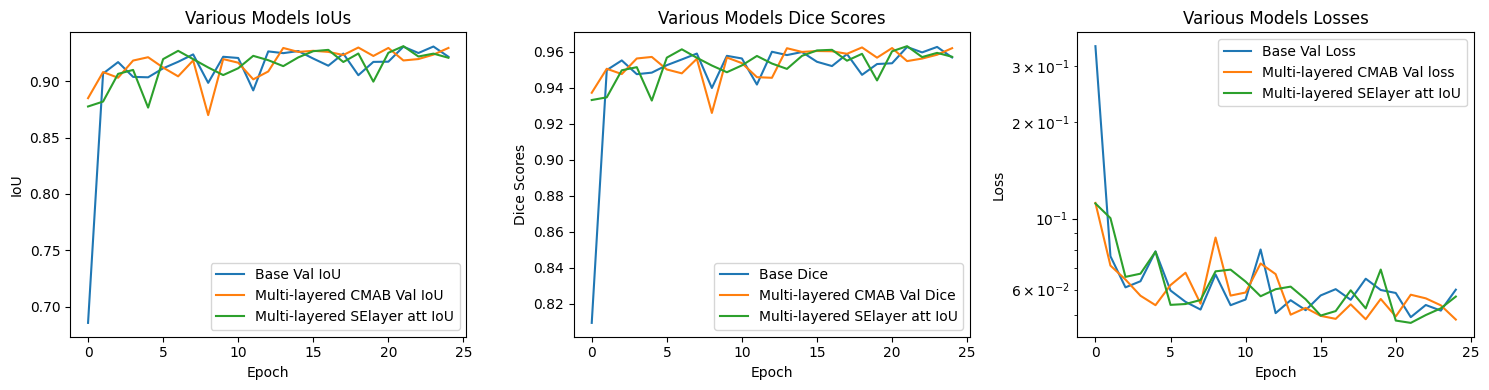

In [14]:
plt.subplots(1, 3, figsize = (15, 4))
plt.title("GRAPH SHOWING VARIOUS ATTENTION IN END & DEC VAL METRICS")

plt.subplot(1, 3, 1)
plt.title("Various Models IoUs")
plt.plot(base_contents["val_ious"], label="Base Val IoU")
plt.plot(cmab_contents["val_ious"], label="Multi-layered CMAB Val IoU")
plt.plot(se_contents["val_ious"], label="Multi-layered SElayer att IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()


plt.subplot(1, 3, 2)
plt.title("Various Models Dice Scores")
plt.plot(base_contents["val_dices"], label="Base Dice")
plt.plot(cmab_contents["val_dices"], label="Multi-layered CMAB Val Dice")
plt.plot(se_contents["val_dices"], label="Multi-layered SElayer att IoU")
plt.xlabel("Epoch")
plt.ylabel("Dice Scores")
plt.legend()


plt.subplot(1, 3, 3)
plt.title("Various Models Losses")
plt.plot(base_contents["val_losses"], label="Base Val Loss")
plt.plot(cmab_contents["val_losses"], label="Multi-layered CMAB Val loss")
plt.plot(se_contents["val_losses"], label="Multi-layered SElayer att IoU")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.yscale('log')

plt.tight_layout()
plt.show()

In [16]:
print(f"""MAX Dice with base model: {max(base_contents["val_dices"])}""")
print(f"""MAX Dice with multiple layer CBAM: {max(cmab_contents["val_dices"])}""")
print(f"""MAX Dice with multiple layer SELayerAttention: {max(se_contents["val_dices"])}\n""")

print(f"""MAX IoU with base model: {max(base_contents["val_ious"])}""")
print(f"""MAX IoU with multiple layer CBAM: {max(cmab_contents["val_ious"])}""")
print(f"""MAX IoU with multiple layer SELayerAttention: {max(se_contents["val_ious"])}\n""")

print(f"""MIN loss with base model: {min(base_contents["val_losses"])}""")
print(f"""MIN loss with multiple layer CBAM: {min(cmab_contents["val_losses"])}""")
print(f"""MIN loss with multiple layer SELayerAttention: {min(se_contents["val_losses"])}""")


MAX Dice with base model: 0.9628029346466065
MAX Dice with multiple layer CBAM: 0.9625215291976928
MAX Dice with multiple layer SELayerAttention: 0.9632229089736939

MAX IoU with base model: 0.9309297323226928
MAX IoU with multiple layer CBAM: 0.9300426244735718
MAX IoU with multiple layer SELayerAttention: 0.9312448263168335

MIN loss with base model: 0.04924309030175209
MIN loss with multiple layer CBAM: 0.048400437086820604
MIN loss with multiple layer SELayerAttention: 0.047255711257457735


# DEEP LABS V3 EXPERIMENTS

In [15]:
criterion = DiceBCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = DeepLabsV3(NUM_CLASSES).to(device)
base_optimizer = optim.Adam(base_model.parameters(), lr = 0.001)
base_model = base_model.to(device)
torch.backends.cudnn.benchmark = True

# Create an instance of the ModelTrainer for base model
base_trainer = ModelTrainer(
    model = base_model,
    criterion = criterion,
    optimizer = base_optimizer,
    train_loader = train_loader,
    validation_loader = validation_loader,
    device = device,
    num_epochs = 25,
    type_ = "base_2"
)

# Training models.
base_contents = base_trainer.train()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 162MB/s]  


Starting training from scratch

Training on: cuda, version 12.1
'base_2' training Started... LET's GOOOOOOO !!!!!
New Best Model Saved! - Lower Loss.
Epoch 1/25 ====== Training : (Loss: 0.2800 - IoU: 0.7502 - Dice: 0.8298) *=* Validation : (Loss: 0.1807 - IoU: 0.8229 - Dice: 0.8991)
New Best Model Saved! - Lower Loss.
Epoch 2/25 ====== Training : (Loss: 0.1214 - IoU: 0.8832 - Dice: 0.9367) *=* Validation : (Loss: 0.0818 - IoU: 0.9116 - Dice: 0.9525)
New Best Model Saved! - Lower Loss.
Epoch 3/25 ====== Training : (Loss: 0.0869 - IoU: 0.8960 - Dice: 0.9443) *=* Validation : (Loss: 0.0726 - IoU: 0.9101 - Dice: 0.9516)
Epoch 4/25 ====== Training : (Loss: 0.0826 - IoU: 0.8919 - Dice: 0.9411) *=* Validation : (Loss: 0.1007 - IoU: 0.8676 - Dice: 0.9258)
Epoch 5/25 ====== Training : (Loss: 0.0833 - IoU: 0.8836 - Dice: 0.9372) *=* Validation : (Loss: 0.0754 - IoU: 0.9082 - Dice: 0.9504)
New Best Model Saved! - Lower Loss.
Epoch 6/25 ====== Training : (Loss: 0.0759 - IoU: 0.8937 - Dice: 0.9428)

In [16]:
cmab_model = DeepLabV3WithCBAM(NUM_CLASSES).to(device)
cmab_optimizer = optim.Adam(cmab_model.parameters(), lr = 0.001)
cmab_model = cmab_model.to(device)
torch.backends.cudnn.benchmark = True

# Create an instance of the ModelTrainer for base model
cmab_trainer = ModelTrainer(
    model = cmab_model,
    criterion = criterion,
    optimizer = cmab_optimizer,
    train_loader = train_loader,
    validation_loader = validation_loader,
    device = device,
    num_epochs = 25,
    type_ = "cbam"
)

# Training models.
cmab_contents = cmab_trainer.train()

Starting training from scratch

Training on: cuda, version 12.1
'cbam' training Started... LET's GOOOOOOO !!!!!
New Best Model Saved! - Lower Loss.
Epoch 1/25 ====== Training : (Loss: 0.2889 - IoU: 0.7251 - Dice: 0.8083) *=* Validation : (Loss: 0.2407 - IoU: 0.7600 - Dice: 0.8603)
New Best Model Saved! - Lower Loss.
Epoch 2/25 ====== Training : (Loss: 0.1224 - IoU: 0.8781 - Dice: 0.9341) *=* Validation : (Loss: 0.0883 - IoU: 0.8989 - Dice: 0.9455)
Epoch 3/25 ====== Training : (Loss: 0.0888 - IoU: 0.8911 - Dice: 0.9415) *=* Validation : (Loss: 0.0983 - IoU: 0.8788 - Dice: 0.9348)
New Best Model Saved! - Lower Loss.
Epoch 4/25 ====== Training : (Loss: 0.0873 - IoU: 0.8827 - Dice: 0.9366) *=* Validation : (Loss: 0.0800 - IoU: 0.8848 - Dice: 0.9354)
Epoch 5/25 ====== Training : (Loss: 0.0778 - IoU: 0.8912 - Dice: 0.9416) *=* Validation : (Loss: 0.1176 - IoU: 0.8471 - Dice: 0.9145)
Epoch 6/25 ====== Training : (Loss: 0.0737 - IoU: 0.8974 - Dice: 0.9451) *=* Validation : (Loss: 0.0858 - IoU:

In [19]:
alternative_attention_model = DeepLabV3WithAlternativeAttention(NUM_CLASSES).to(device)
alternative_attention_optimizer = optim.Adam(alternative_attention_model.parameters(), lr = 0.001)
alternative_attention_model = alternative_attention_model.to(device)
torch.backends.cudnn.benchmark = True

# Create an instance of the ModelTrainer for base model
alternative_attention_trainer = ModelTrainer(
    model = alternative_attention_model,
    criterion = criterion,
    optimizer = alternative_attention_optimizer,
    train_loader = train_loader,
    validation_loader = validation_loader,
    device = device,
    num_epochs = 25,
    type_ = "alt_attention"
)

# Training models.
alternative_attention_contents = alternative_attention_trainer.train()

In [20]:
selayer_attention_model = DeepLabV3WithSELayerAttention(NUM_CLASSES).to(device)
selayer_attention_optimizer = optim.Adam(selayer_attention_model.parameters(), lr = 0.001)
selayer_attention_model = selayer_attention_model.to(device)
torch.backends.cudnn.benchmark = True

# Create an instance of the ModelTrainer for base model
selayer_attention_trainer = ModelTrainer(
    model = selayer_attention_model,
    criterion = criterion,
    optimizer = selayer_attention_optimizer,
    train_loader = train_loader,
    validation_loader = validation_loader,
    device = device,
    num_epochs = 25,
    type_ = "selayer_attention"
)

# Training models.
selayer_attention_contents = selayer_attention_trainer.train()

Starting training from scratch

Training on: cuda, version 12.1
'selayer_attention' training Started... LET's GOOOOOOO !!!!!
New Best Model Saved! - Lower Loss.
Epoch 1/25 ====== Training : (Loss: 0.2569 - IoU: 0.7234 - Dice: 0.7990) *=* Validation : (Loss: 0.1341 - IoU: 0.8812 - Dice: 0.9358)
New Best Model Saved! - Lower Loss.
Epoch 2/25 ====== Training : (Loss: 0.1011 - IoU: 0.8886 - Dice: 0.9401) *=* Validation : (Loss: 0.0758 - IoU: 0.9141 - Dice: 0.9539)
Epoch 3/25 ====== Training : (Loss: 0.0816 - IoU: 0.8924 - Dice: 0.9422) *=* Validation : (Loss: 0.0870 - IoU: 0.8900 - Dice: 0.9405)
New Best Model Saved! - Lower Loss.
Epoch 4/25 ====== Training : (Loss: 0.0827 - IoU: 0.8876 - Dice: 0.9390) *=* Validation : (Loss: 0.0592 - IoU: 0.9148 - Dice: 0.9545)
New Best Model Saved! - Lower Loss.
Epoch 5/25 ====== Training : (Loss: 0.0701 - IoU: 0.9005 - Dice: 0.9468) *=* Validation : (Loss: 0.0573 - IoU: 0.9203 - Dice: 0.9571)
Epoch 6/25 ====== Training : (Loss: 0.0714 - IoU: 0.9004 - Di

In [32]:
cmab_se_attention_model = DeepLabV3WithCbamSEAlternativeAttention(NUM_CLASSES).to(device)
cmab_se_attention_optimizer = optim.Adam(cmab_se_attention_model.parameters(), lr = 0.001)
cmab_se_attention_model = cmab_se_attention_model.to(device)
torch.backends.cudnn.benchmark = True

# Create an instance of the ModelTrainer for base model
cmab_se_attention_trainer = ModelTrainer(
    model = cmab_se_attention_model,
    criterion = criterion,
    optimizer = cmab_se_attention_optimizer,
    train_loader = train_loader,
    validation_loader = validation_loader,
    device = device,
    num_epochs = 25,
    type_ = "cmab_se_layer_attention"
)

# Training models.
cmab_se_attention_contents = cmab_se_attention_trainer.train()

Starting training from scratch

Training on: cuda, version 12.1
'cmab_se_layer_attention' training Started... LET's GOOOOOOO !!!!!
New Best Model Saved! - Lower Loss.
Epoch 1/25 ====== Training : (Loss: 0.3010 - IoU: 0.7083 - Dice: 0.7932) *=* Validation : (Loss: 0.1403 - IoU: 0.8785 - Dice: 0.9336)
New Best Model Saved! - Lower Loss.
Epoch 2/25 ====== Training : (Loss: 0.1234 - IoU: 0.8721 - Dice: 0.9307) *=* Validation : (Loss: 0.0942 - IoU: 0.8893 - Dice: 0.9401)
New Best Model Saved! - Lower Loss.
Epoch 3/25 ====== Training : (Loss: 0.0911 - IoU: 0.8849 - Dice: 0.9380) *=* Validation : (Loss: 0.0873 - IoU: 0.8940 - Dice: 0.9416)
New Best Model Saved! - Lower Loss.
Epoch 4/25 ====== Training : (Loss: 0.0814 - IoU: 0.8914 - Dice: 0.9415) *=* Validation : (Loss: 0.0637 - IoU: 0.9196 - Dice: 0.9568)
Epoch 5/25 ====== Training : (Loss: 0.0753 - IoU: 0.8957 - Dice: 0.9442) *=* Validation : (Loss: 0.1154 - IoU: 0.8523 - Dice: 0.9192)
New Best Model Saved! - Lower Loss.
Epoch 6/25 ====== T

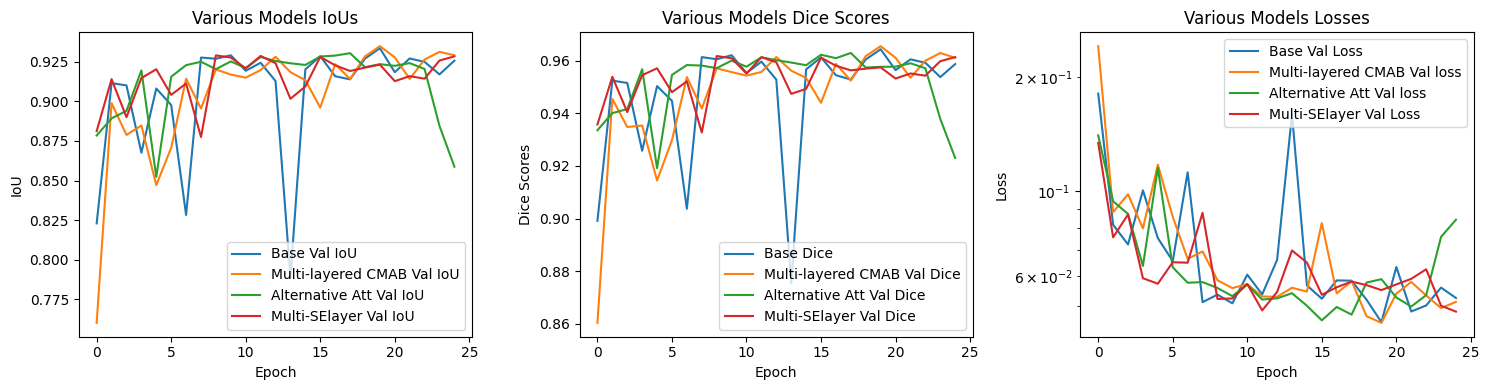

In [33]:
plt.subplots(1, 3, figsize = (15, 4))
plt.title("GRAPH SHOWING VARIOUS ATTENTION IN END & DEC VAL METRICS")

plt.subplot(1, 3, 1)
plt.title("Various Models IoUs")
plt.plot(base_contents["val_ious"], label="Base Val IoU")
plt.plot(cmab_contents["val_ious"], label="Multi-layered CMAB Val IoU")
plt.plot(cmab_se_attention_contents["val_ious"], label="Alternative Att Val IoU")
plt.plot(selayer_attention_contents["val_ious"], label="Multi-SElayer Val IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()


plt.subplot(1, 3, 2)
plt.title("Various Models Dice Scores")
plt.plot(base_contents["val_dices"], label="Base Dice")
plt.plot(cmab_contents["val_dices"], label="Multi-layered CMAB Val Dice")
plt.plot(cmab_se_attention_contents["val_dices"], label="Alternative Att Val Dice")
plt.plot(selayer_attention_contents["val_dices"], label="Multi-SElayer Val Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice Scores")
plt.legend()


plt.subplot(1, 3, 3)
plt.title("Various Models Losses")
plt.plot(base_contents["val_losses"], label="Base Val Loss")
plt.plot(cmab_contents["val_losses"], label="Multi-layered CMAB Val loss")
plt.plot(cmab_se_attention_contents["val_losses"], label="Alternative Att Val loss")
plt.plot(selayer_attention_contents["val_losses"], label="Multi-SElayer Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.yscale('log')

plt.tight_layout()
plt.show()

In [34]:
print(f"""MAX Dice with base model: {max(base_contents["val_dices"])}""")
print(f"""MAX Dice with multiple layer CBAM: {max(cmab_contents["val_dices"])}""")
print(f"""MAX Dice with multiple layer SELayerAttention: {max(selayer_attention_contents["val_dices"])}""")
print(f"""MAX Dice with Alternative Attention: {max(cmab_se_attention_contents["val_dices"])}""")
print("")
print(f"""MAX IoU with base model: {max(base_contents["val_ious"])}""")
print(f"""MAX IoU with multiple layer CBAM: {max(cmab_contents["val_ious"])}""")
print(f"""MAX IoU with multiple layer SELayerAttention: {max(selayer_attention_contents["val_ious"])}""")
print(f"""MAX IoU with Alternative Attention: {max(cmab_se_attention_contents["val_ious"])}""")
print("")

print(f"""MIN loss with base model: {min(base_contents["val_losses"])}""")
print(f"""MIN loss with multiple layer CBAM: {min(cmab_contents["val_losses"])}""")
print(f"""MIN loss with multiple layer SELayerAttention: {min(selayer_attention_contents["val_losses"])}""")
print(f"""MIN loss with Alternative Attention: {min(cmab_se_attention_contents["val_losses"])}""")

MAX Dice with base model: 0.9643720746040344
MAX Dice with multiple layer CBAM: 0.9655493378639222
MAX Dice with multiple layer SELayerAttention: 0.9617993831634521
MAX Dice with Alternative Attention: 0.9629647850990295

MAX IoU with base model: 0.9336557030677796
MAX IoU with multiple layer CBAM: 0.9349462270736695
MAX IoU with multiple layer SELayerAttention: 0.9291139245033264
MAX IoU with Alternative Attention: 0.9305152535438538

MIN loss with base model: 0.045379336923360825
MIN loss with multiple layer CBAM: 0.04518663659691811
MIN loss with multiple layer SELayerAttention: 0.04837305434048176
MIN loss with Alternative Attention: 0.04588663280010223


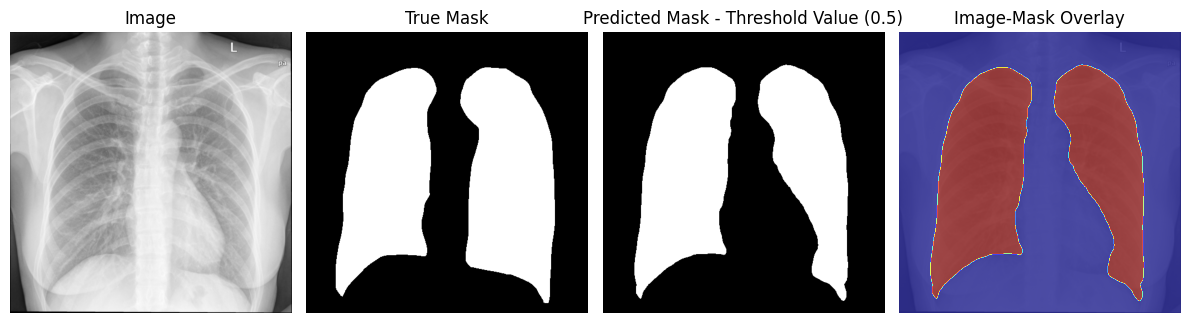

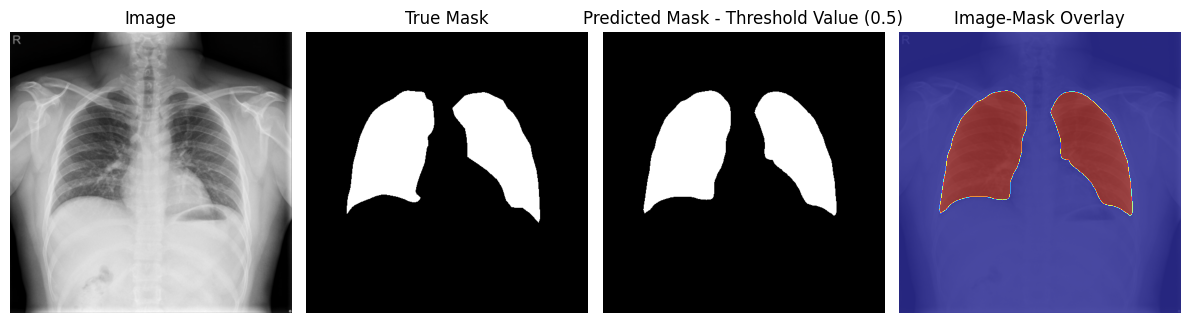

In [23]:
pred_nd_plot(test_loader, base_contents["model"], device, image_denormalize, pred_threshold = 0.5, num_images = 2)

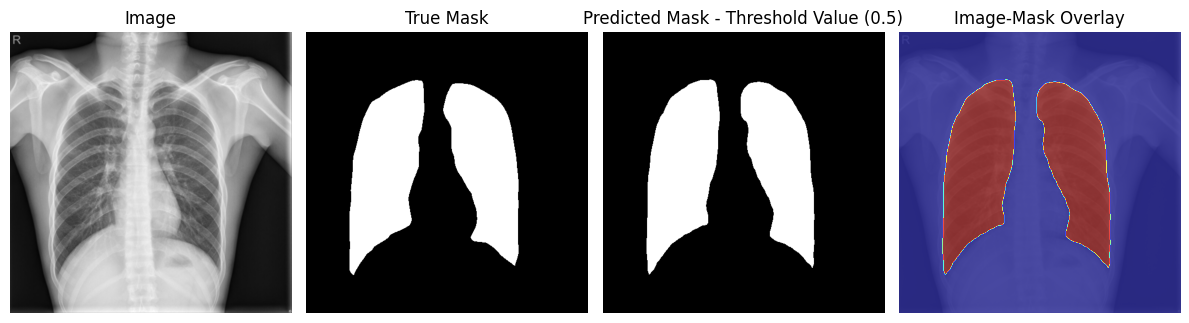

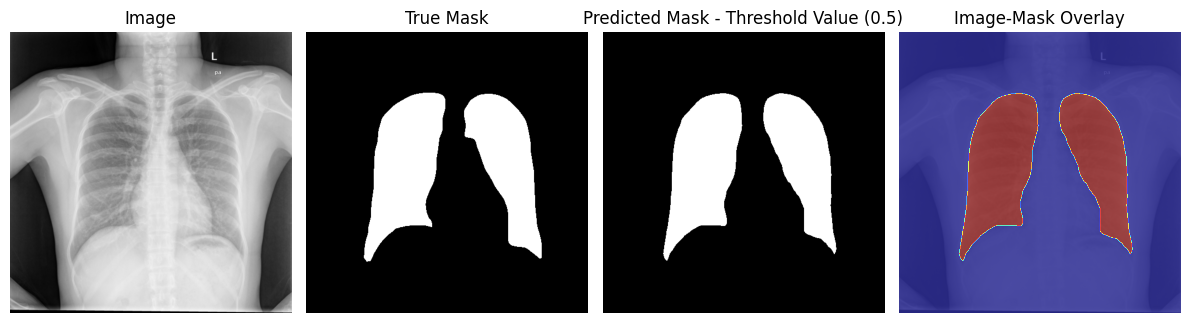

In [24]:
pred_nd_plot(test_loader, cmab_contents["model"], device, image_denormalize, pred_threshold = 0.5, num_images = 2)

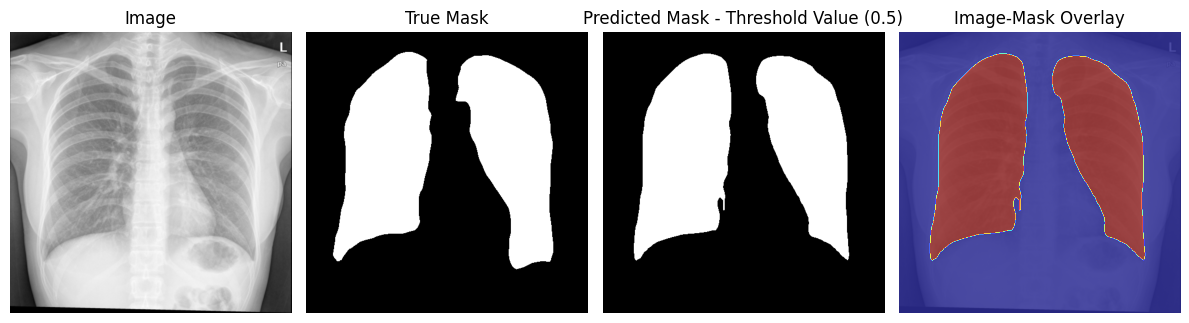

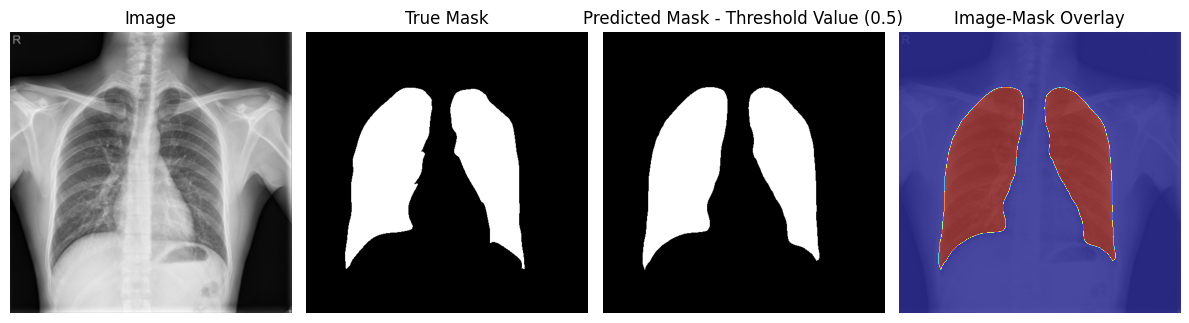

In [25]:
pred_nd_plot(test_loader, selayer_attention_contents["model"], device, image_denormalize, pred_threshold = 0.5, num_images = 2)

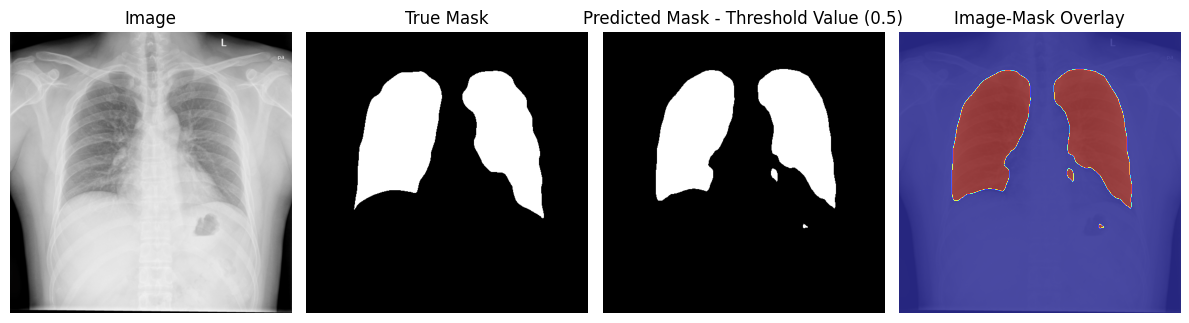

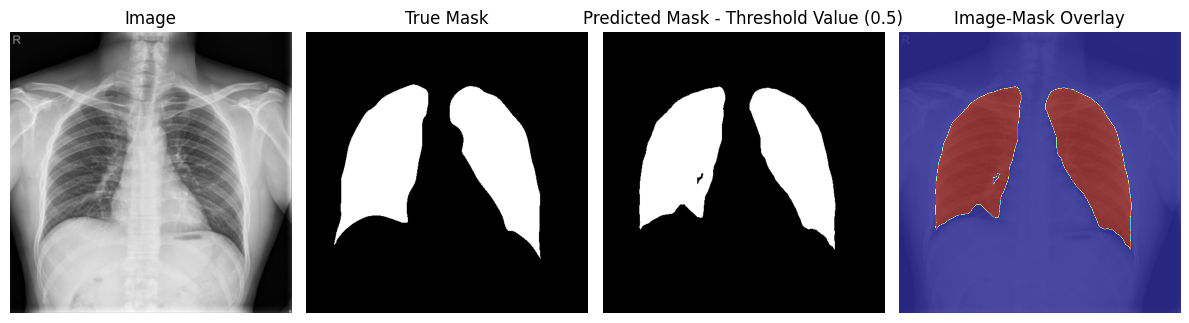

In [35]:
pred_nd_plot(test_loader, cmab_se_attention_contents["model"], device, image_denormalize, pred_threshold = 0.5, num_images = 2)

# Comparing "Best" models predictions

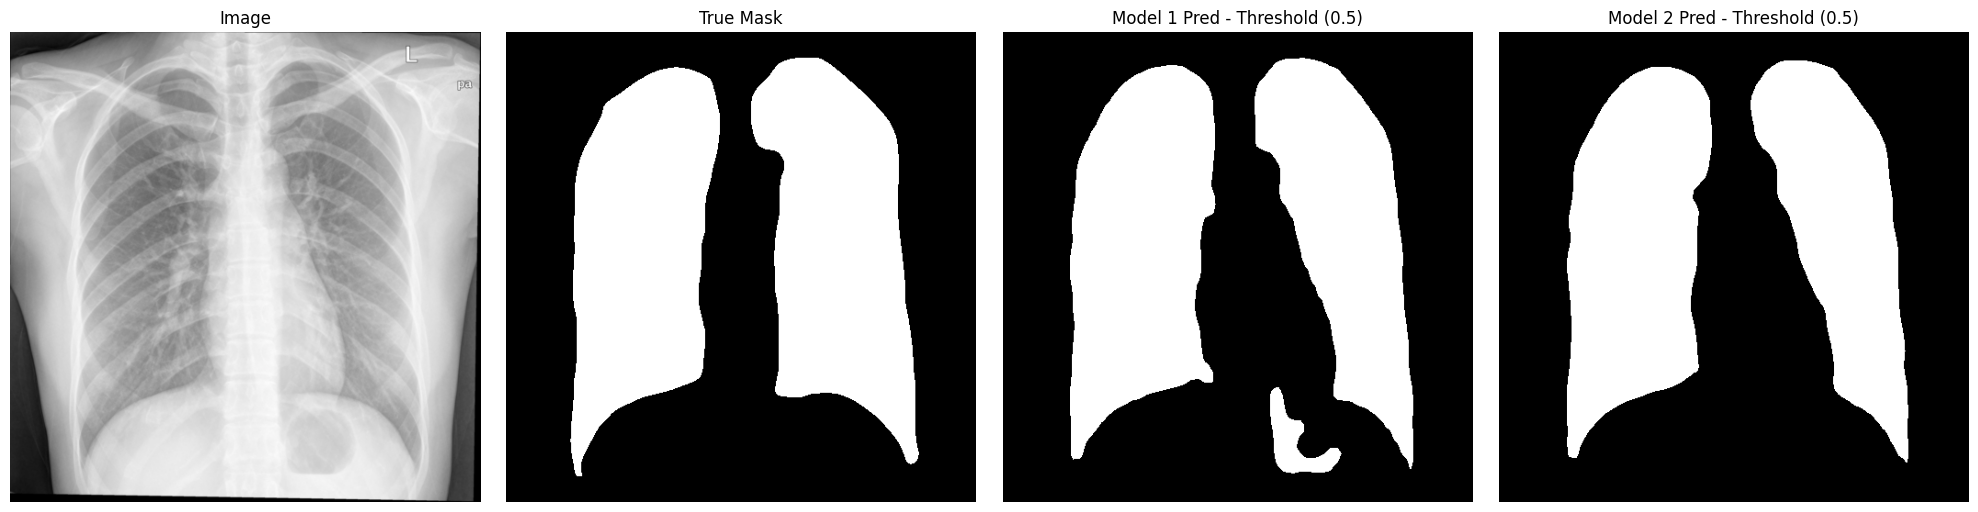

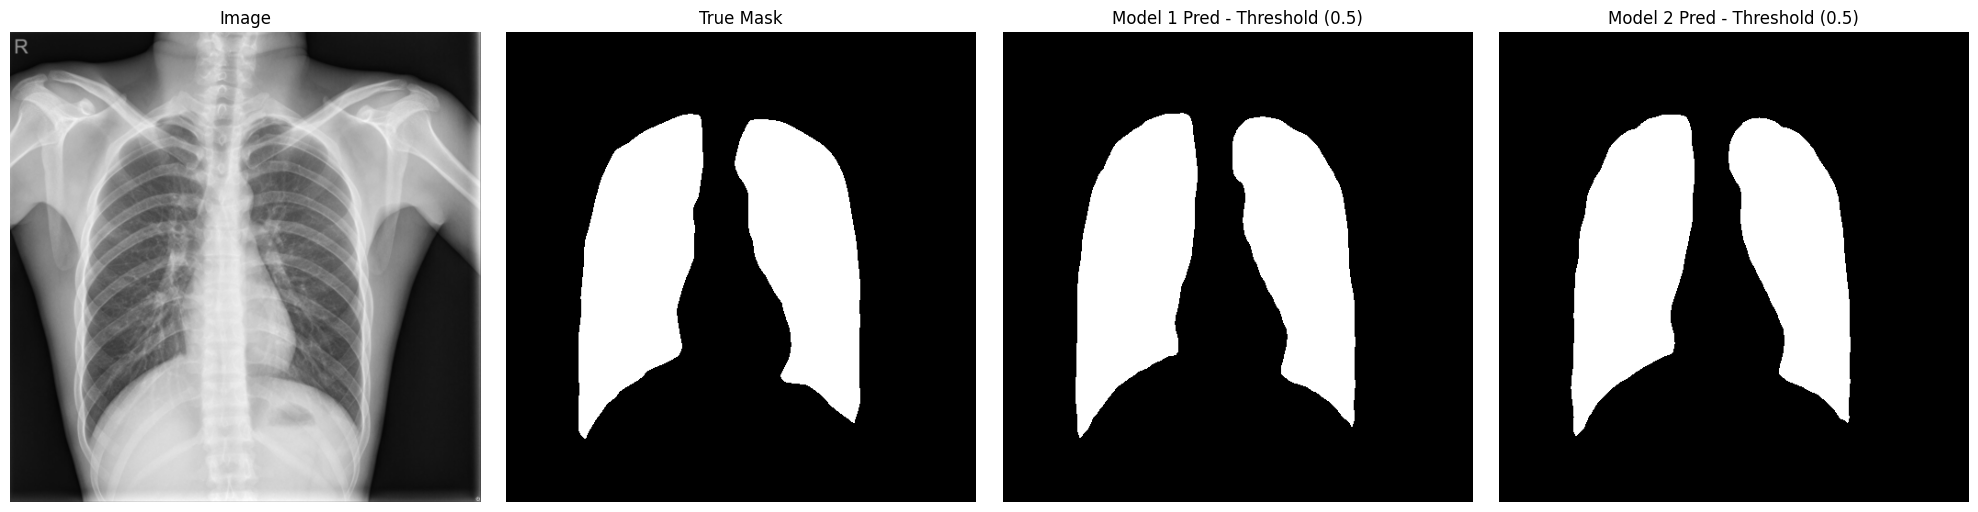

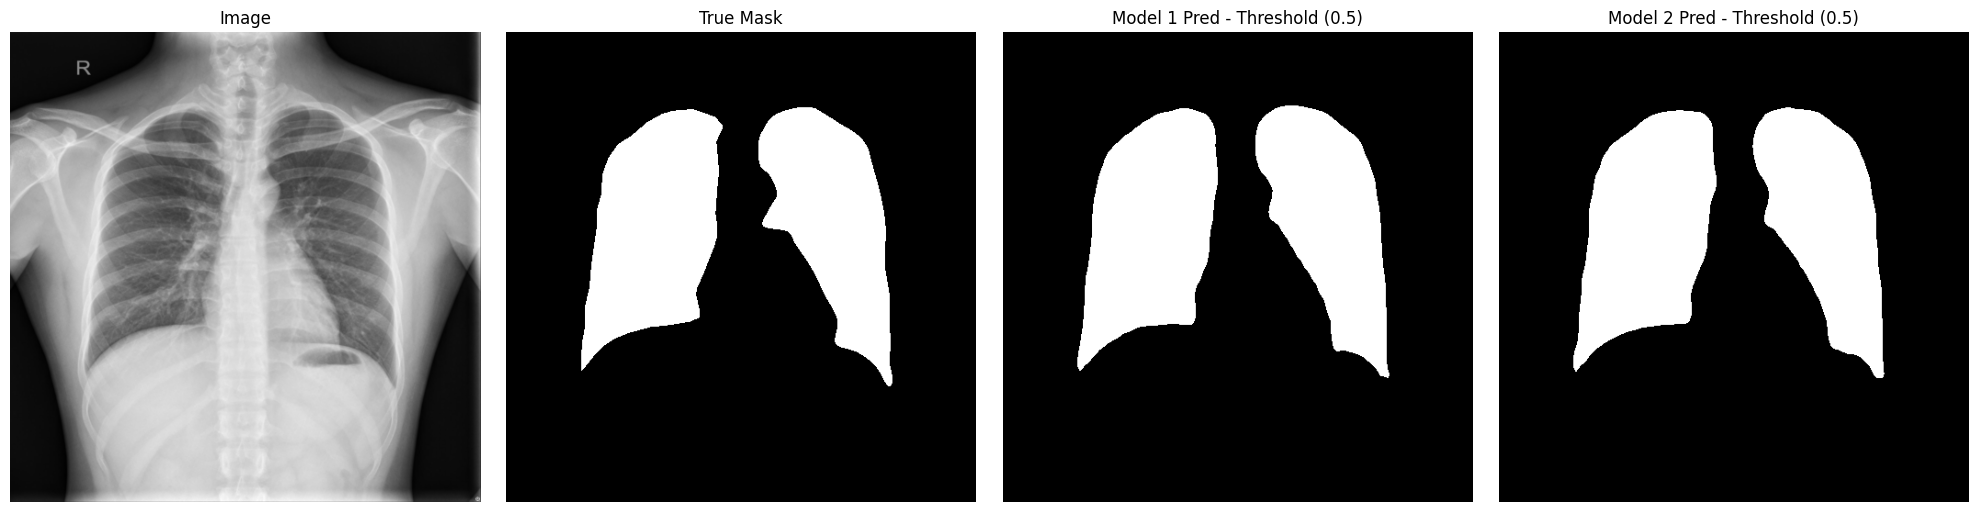

In [38]:
pred_plot_compare(test_loader, cmab_contents["model"], selayer_attention_contents["model"], device, image_denormalize, pred_threshold = 0.5, num_images = 3)

In [75]:
ENCandDEC_CMAB_model = DeepLabV3WithCBAMInENDandDEC(NUM_CLASSES).to(device)
ENCandDEC_CMAB_optimizer = optim.Adam(ENCandDEC_CMAB_model.parameters(), lr = 0.001)
ENCandDEC_CMAB_model = ENCandDEC_CMAB_model.to(device)
torch.backends.cudnn.benchmark = True

ENCandDEC_CMAB_model_trainer = ModelTrainer(
    model = ENCandDEC_CMAB_model,
    criterion = criterion,
    optimizer = ENCandDEC_CMAB_optimizer,
    train_loader = train_loader,
    validation_loader = validation_loader,
    device = device,
    num_epochs = 25,
    type_ = "ENCandDEC_CMAB_2"
)

# Training models
ENCandDEC_CMAB_model_contents = ENCandDEC_CMAB_model_trainer.train()

Starting training from scratch

Training on: cuda, version 12.1
'ENCandDEC_CMAB_2' training Started... LET's GOOOOOOO !!!!!
New Best Model Saved! - Lower Loss.
Epoch 1/25 ====== Training : (Loss: 0.6607 - IoU: 0.7116 - Dice: 0.8091) *=* Validation : (Loss: 0.6340 - IoU: 0.8026 - Dice: 0.8897)
New Best Model Saved! - Lower Loss.
Epoch 2/25 ====== Training : (Loss: 0.6184 - IoU: 0.8709 - Dice: 0.9300) *=* Validation : (Loss: 0.6125 - IoU: 0.8982 - Dice: 0.9447)
New Best Model Saved! - Lower Loss.
Epoch 3/25 ====== Training : (Loss: 0.6108 - IoU: 0.8828 - Dice: 0.9365) *=* Validation : (Loss: 0.6091 - IoU: 0.9028 - Dice: 0.9478)
New Best Model Saved! - Lower Loss.
Epoch 4/25 ====== Training : (Loss: 0.6062 - IoU: 0.8968 - Dice: 0.9449) *=* Validation : (Loss: 0.6058 - IoU: 0.9113 - Dice: 0.9527)
Epoch 5/25 ====== Training : (Loss: 0.6060 - IoU: 0.8926 - Dice: 0.9424) *=* Validation : (Loss: 0.6062 - IoU: 0.9023 - Dice: 0.9477)
Epoch 6/25 ====== Training : (Loss: 0.6072 - IoU: 0.8759 - Dic

# Garbage cleaning.

In [37]:
# gc.collect()
# shutil.rmtree("/kaggle/working/ModelTrainingCheckpoint")
# shutil.rmtree("/kaggle/working/lungs")